In [47]:
import pandas as pd
import numpy as np
import sys
pd.set_option('display.max_columns',30)
import scipy.stats as ss
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from scipy.optimize import curve_fit

In [2]:
df = pd.read_csv('covid19daily.csv')
df['date'] = pd.to_datetime(df.Date,dayfirst=True)
df = df.drop(['Date'],axis=1)
#rearrange
cols = list(df.columns)
cols.insert(0,cols.pop())
df = df[cols]

# Calculated Columns

In [3]:
df['TotalPositive'] = df['NewPositive'].cumsum()

In [4]:
df['TotalTests'] = df.NewPositive+df.DailyNegTest

In [5]:
# Note My Cumulative number of tests won't match province because there were approx 378 tests carried out prior to March 6 which are not reflected here
df['CumPeopleTested']=df['TotalTests'].cumsum()

In [6]:
# Alberta Population from https://economicdashboard.alberta.ca/Population
totalpop = 4413146

In [7]:
df['percentTestsperPop'] = (df.CumPeopleTested)/totalpop*100

In [8]:
df['percTestperDayperPop'] = df.TotalTests/totalpop*100

In [9]:
df['percHospPerPositiveTest'] = df.Total_Hospitalized/df.TotalPositive*100

In [10]:
df['percICUPerPostitiveTest'] = df.Total_ICU/df.TotalPositive*100

In [11]:
df['percICUPerHospitalized'] = df.Total_ICU/df.Total_Hospitalized*100

In [12]:
# CFR = Case Fatality Rate
df['perc_CFR'] = df.Cumulative_Deaths/df.TotalPositive*100

In [13]:
df['perc_MortalityRate'] = df.Cumulative_Deaths/totalpop*100

# Modeling logarithmic growth

In [48]:
df.tail()

,date,NewPositive,DailyNegTest,Total_Hospitalized,Total_ICU,Cumulative_Deaths,RecoveredToDate,TotalPositive,TotalTests,CumPeopleTested,percentTestsperPop,percTestperDayperPop,percHospPerPositiveTest,percICUPerPostitiveTest,percICUPerHospitalized,perc_CFR,perc_MortalityRate
23,2020-03-29,29,1871,41,14,3,73,686,1900,45016,1.020043,0.043053,5.976676,2.040816,34.146341,0.437318,0.000068
24,2020-03-30,51,2613,41,14,8,94,737,2664,47680,1.080408,0.060365,5.563094,1.899593,34.146341,1.085482,0.000181
25,2020-03-31,127,4456,47,17,9,120,864,4583,52263,1.184257,0.103849,5.439815,1.967593,36.170213,1.041667,0.000204
26,2020-04-01,88,3602,29,13,11,142,952,3690,55953,1.267871,0.083614,3.046218,1.365546,44.827586,1.155462,0.000249
27,2020-04-02,15,923,32,14,13,174,967,938,56891,1.289126,0.021255,3.309204,1.447777,43.750000,1.344364,0.000295


In [15]:
df.head()

,date,NewPositive,DailyNegTest,Total_Hospitalized,Total_ICU,Cumulative_Deaths,RecoveredToDate,TotalPositive,TotalTests,CumPeopleTested,percentTestsperPop,percTestperDayperPop,percHospPerPositiveTest,percICUPerPostitiveTest,percICUPerHospitalized,perc_CFR,perc_MortalityRate
0,2020-03-06,1,61,0,0,0,0,1,62,62,0.001405,0.001405,0.00,0.0,NaN,0.0,0.0
1,2020-03-07,0,274,0,0,0,0,1,274,336,0.007614,0.006209,0.00,0.0,NaN,0.0,0.0
2,2020-03-08,0,440,0,0,0,0,1,440,776,0.017584,0.009970,0.00,0.0,NaN,0.0,0.0
3,2020-03-09,6,718,0,0,0,0,7,724,1500,0.033989,0.016406,0.00,0.0,NaN,0.0,0.0
4,2020-03-10,9,965,1,0,0,0,16,974,2474,0.056060,0.022070,6.25,0.0,0.0,0.0,0.0


# Plots

## Fit for log/log plot

In [16]:
def llfunc(x,a,b):
    return 10**(a*np.log10(x)+b)

In [17]:
# Fit whole range of data
popt,pcov = curve_fit(llfunc,df.TotalPositive,df.NewPositive)
popt

array([0.49129208, 0.40506868])

In [18]:
# Fit all x except last few points (if indeed they are 'dropping off')
x2 = df.TotalPositive[df.TotalPositive<600]
y2 = df.NewPositive[df.TotalPositive<600]
p2opt,p2cov = curve_fit(llfunc,x2,y2)
p2opt

array([0.66246793, 0.02080195])

## Calculate Transmission Rate

In [19]:
def transmission_rate(x,a,b):
    return 10**(a*x+b)
# Early
earlyy = df.TotalPositive[df.date<'2020-03-13']
earlyx = df.index[df.date<'2020-03-13']
ropt,rcov = curve_fit(transmission_rate,earlyx,earlyy)

In [20]:
# Late
latey = df.TotalPositive[df.date>'2020-03-13']
latex = df.index[df.date>'2020-03-13']
ropt2,rcov2 = curve_fit(transmission_rate,latex,latey)

## Calculate % Hospitalized and % ICU and % death

In [58]:
hosp = df.percHospPerPositiveTest[df.date>'2020-03-09'].mean()
icu = df.percICUPerPostitiveTest[df.date>'2020-03-15'].mean()
dead1 = df.perc_CFR[df.date>'2020-03-19'].mean()
dead2 = df.perc_CFR[df.date>'2020-03-26'].mean()

## Create Plots

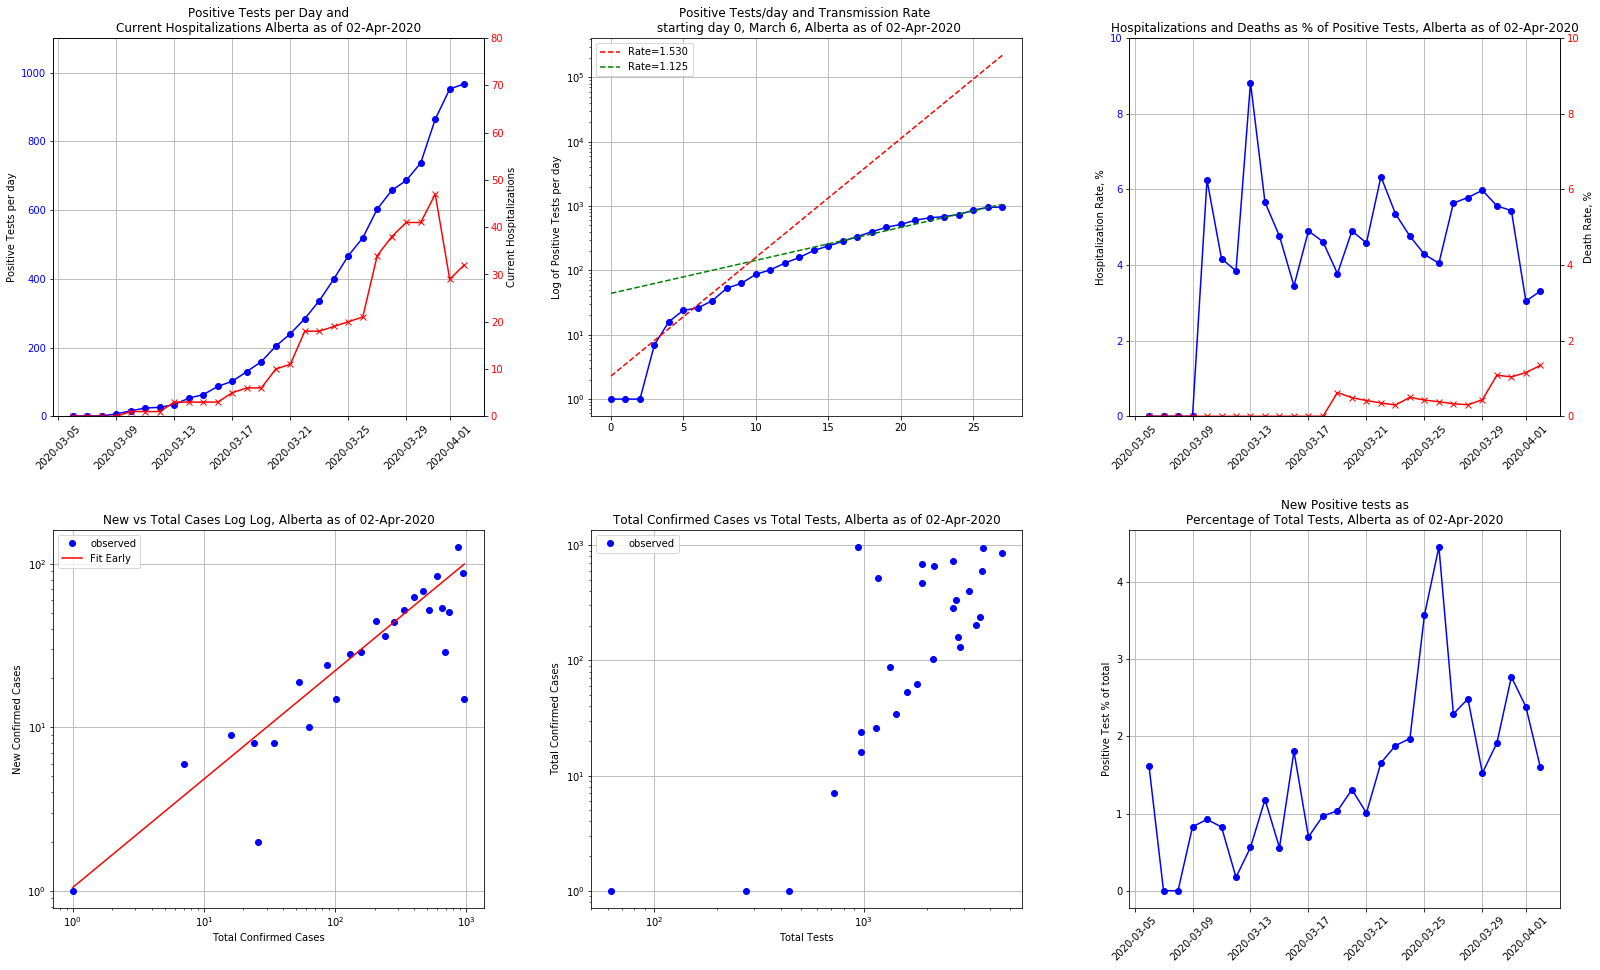

In [64]:
# Get last date in dataframe for graph header
datadate = df.date.iat[-1].strftime("%d-%b-%Y")

def two_scales(ax1,xdata,data1,data2,c1,f1,l1,c2,f2,l2,y1text,y2text):
    ax2 = ax1.twinx()
    ax1.plot(xdata,data1,color=c1,marker=f1,linestyle=l1)
    ax1.set_ylabel(y1text)
    ax2.plot(xdata,data2,color=c2,marker=f2,linestyle=l2)
    ax2.set_ylabel(y2text)
    return ax1,ax2

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6))= plt.subplots(2,3,figsize=(27,16))

ax1, ax1a = two_scales(ax1,df.date,df.TotalPositive,df.Total_Hospitalized,
                       'blue','o','-','red','x','-',
                       'Positive Tests per day','Current Hospitalizations')
ax1.set_title(f"Positive Tests per Day and\nCurrent Hospitalizations Alberta as of {datadate}")
ax1.grid(True)

def color_y_axis(ax, color):
    """Color your axes."""
    for t in ax.get_yticklabels():
        t.set_color(color)

color_y_axis(ax1, 'b')
color_y_axis(ax1a, 'r')
ax1a.set_ylim([0,80])
ax1.set_ylim([0,1100])
ax1.tick_params(axis='x',rotation=45)

ax2.plot(df.index,df.TotalPositive,'-ob')
ax2.set_yscale("log")
ax2.set_title(f"Positive Tests/day and Transmission Rate \n starting day 0, March 6, Alberta as of {datadate}")
ax2.grid(True)
ax2.plot(df.index,transmission_rate(df.index,*ropt),'r--',label=f"Rate={10**(ropt[0]):.3f}")
ax2.plot(df.index,transmission_rate(df.index,*ropt2),'g--',label=f"Rate={10**(ropt2[0]):.3f}")
ax2.set_ylabel("Log of Positive Tests per day")
ax2.legend()

ax3, ax3a = two_scales(ax3,df.date,df.percHospPerPositiveTest,df.perc_CFR,
                       'blue','o','-','red','x','-',
                       'Hospitalization Rate, %','Death Rate, %')
ax3.set_title(f"Hospitalizations and Deaths as % of Positive Tests, Alberta as of {datadate}")
ax3.grid(True)
color_y_axis(ax3, 'b')
color_y_axis(ax3a, 'r')
ax3a.set_ylim([0,10])
ax3.set_ylim([0,10])
ax3.tick_params(axis='x',rotation=45)



ax4.plot(df.TotalPositive,df.NewPositive,'ob',label='observed')
ax4.set_title(f"New vs Total Cases Log Log, Alberta as of {datadate}")
ax4.set_ylabel("New Confirmed Cases")
ax4.set_xlabel("Total Confirmed Cases")
ax4.grid(True)
ax4.set_yscale("log")
ax4.set_xscale("log")
ax4.plot(df.TotalPositive,llfunc(df.TotalPositive,*p2opt),'r-',label='Fit Early')
ax4.legend()

ax5.plot(df.TotalTests,df.TotalPositive,'ob',label='observed')
ax5.set_title(f"Total Confirmed Cases vs Total Tests, Alberta as of {datadate}")
ax5.set_ylabel("Total Confirmed Cases")
ax5.set_xlabel("Total Tests")
ax5.grid(True)
ax5.set_yscale("log")
ax5.set_xscale("log")
#ax5.plot(df.TotalPositive,llfunc(df.TotalPositive,*p2opt),'r-',label='Fit Early')
ax5.legend()

ax6.plot(df.date,(df.NewPositive/df.TotalTests*100),'-ob')
ax6.set_title(f"New Positive tests as\nPercentage of Total Tests, Alberta as of {datadate}")
ax6.set_ylabel("Positive Test % of total")
ax6.grid(True)
ax6.tick_params(axis='x',rotation=45)

plt.subplots_adjust(wspace=0.25,hspace=0.3)
plt.show()

# Predict ICU Beds and Hosptalizations at Day X

In [27]:
#Input desired Forecast Date:
dates = ['2020-04-15','2020-04-29','2020-05-06','2020-05-20']

In [60]:
def forecast(d):
    
    future = datetime.strptime(d,"%Y-%m-%d")
    elapsed = (future - df.date.iloc[0]).days
    
    # Calculate future positive tests using later transmission rate and hospitalizations and ICU admissions as a function of the positive tests
    pos_tests_future = transmission_rate(elapsed,*ropt2)
    hosp_future = hosp/100*pos_tests_future
    icu_future = icu/100*pos_tests_future
    dead_future1 = dead1/100*pos_tests_future
    dead_future2 = dead2/100*pos_tests_future

    # Print results
    print(f"Forecast date: {d}")
    print(f"Yields:\n{pos_tests_future:.0f} positive tests on that day\n{hosp_future:.0f} people in hospital\n{icu_future:.0f} people in ICU\n{dead_future1:.0f}-{dead_future2:.0f} people dead\n")

    return

In [61]:
# Get Current date as last date of data in dataframe
current = df.date.iloc[-1].date()

# Print results
print(f"Current date: {current}")
print(f"Deaths to current date (not forecast): {df.Cumulative_Deaths.iloc[-1]}")
print(f"Mean Hospitalization/positve test {hosp:.2f}% and mean ICU/Positive Test: {icu:.2f}%")
print(f"Using transmission rate of {(10**ropt2[0]):.3f}\n")

for d in dates:
    forecast(d)

Current date: 2020-04-02
Deaths to current date (not forecast): 13
Mean Hospitalization/positve test 4.97% and mean ICU/Positive Test: 1.95%
Using transmission rate of 1.125

Forecast date: 2020-04-15
Yields:
4948 positive tests on that day
246 people in hospital
96 people in ICU
30-40 people dead

Forecast date: 2020-04-29
Yields:
25846 positive tests on that day
1284 people in hospital
504 people in ICU
158-210 people dead

Forecast date: 2020-05-06
Yields:
59069 positive tests on that day
2936 people in hospital
1152 people in ICU
362-481 people dead

Forecast date: 2020-05-20
Yields:
308529 positive tests on that day
15333 people in hospital
6015 people in ICU
1889-2512 people dead

